# Cyclone Detection by Convolutional Neural Network (CNN)

Cyclones are the large scale intense circular storm that originates over warm tropical oceans and is characterized by low atmospheric pressure, high winds and heavy rain.
Variously referred to as hurricane or typhoon, cyclone has a significant socio-economic impact.
The accurate forecast of the cyclone track has been a significant achievement of modern meteorology. 
Aided by the development of satellites and improved computational power, cyclone predictability has improved over the years.
Recently with the advent of machine learning, attempts have been made to predict the cyclone genesis [(Zhang and Lin, 2019)](https://journals.ametsoc.org/doi/abs/10.1175/WAF-D-18-0201.1), cyclone track [(Kim et al, 2018)](https://openreview.net/pdf?id=HJlCVoPAF7), cyclone intensity [(Miller)](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20170011716.pdf) as well as other aspects of cyclone.


In this notebook I have tried to detect the presence of cyclone using the convolutional neural network. Relative vorticity and geopotential height at 500 hPa as well as mean sea level pressure and total cloud cover are used as inputs for the model. These fields are obtained from [ERA_Interim](https://apps.ecmwf.int/datasets/data/interim-full-daily/levtype=sfc/) reanalysis dataset, which is a 4X daily data with a resolution of 0.75 deg. In this study only the cyclones occuring in Atlantic basin is considered. A list of atlantic basin cyclonic disturbances can be found here (https://www.kaggle.com/noaa/hurricane-database) and (https://www.nhc.noaa.gov/data/). This data is used to create the target variable, which is assigned 1 if cyclonic disturbance is present and 0 otherwise. For simplicity I have considered all the disturbances regardless of its strength as cyclone. Data from the years 1979-2015 is used.

[Hurrican Wilma](https://en.wikipedia.org/wiki/Hurricane_Wilma) was one of the strongest hurricane recorded in the Atlantic basin. The following plot shows the mean sea level pressure (in color having the units of hPa) and relative vorticity at 500 hPa (only positive values are shown in red contours) during the various phases of cyclone development. All the plots are at 00 hrs UTC. The cyclone intensified around October 19th near Cayman Islands and progressed North-East crossing Florida hugging along the east coast of USA. It finally dissipated around October 27th.

<img src="Data/cycloneVrt.png" width="1500">

 	

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import keras
import xarray
plt.ion()

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/home/suhas/Desktop/DeepWeather/Data/cyclone/atlantic_hurricane_kaggle.csv', sep=',')
hours = [0,600,1200,1800]
data = data[data['Time'].isin(hours)]
time = pd.to_datetime(data['Date'], format='%Y%m%d')+ pd.to_timedelta(data['Time']/100, unit='h')
time = time[(time.dt.year >= 1979) & (time.dt.year <= 2015)]
data.tail()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0
49104,AL122015,KATE,20151113,1200,,EX,40.7N,45.4W,45,987,...,150,220,0,0,0,0,0,0,0,0


6 hour time stamps are generated between 1970-2015. 
If the cyclonic activites are present cyclone_label is assigned 1 else 0.

In [3]:
time_new = pd.date_range(start='1/1/1979', end='1/1/2016', freq='6h')
time_new = time_new[0:-1]
cyclone_label = np.zeros(len(time_new))
cyclone_label[time_new.isin(time)] = 1
cyclone_label = cyclone_label.astype(int)

Read reanalysis data.

In [4]:
def extractData(filePath,var, yearMin, yearMax):
    data = xarray.open_dataset(filePath)
    out  = data[var]
    tm  = data.time.dt.year   
    out  = out[(tm >= yearMin) & (tm <= yearMax)]
    out  = (out - np.mean(out))/np.std(out)
    data.close()
    return out

In [5]:
pr    = extractData('Data/cyclone/era_surface.nc', 'msl', 1979, 2015)
cloud = extractData('Data/cyclone/era_surface.nc', 'tcc', 1979, 2015)
vrt   = extractData('Data/cyclone/era_500.nc', 'vo', 1979, 2015)
geopt = extractData('Data/cyclone/era_500.nc', 'z', 1979, 2015)

In [6]:
print ("Ratio of cyclonic activity :", np.sum(cyclone_label)/len(cyclone_label))

Ratio of cyclonic activity : 0.2093014651472547


Only about 20% of the times experience cyclonic activities. This uneven distribution of data could result in incorrect classification. For example the model could simply classify all the outputs as non-cyclonic and still end up with 80% accuracy. So equal number of cyclonic and non-cyclonic times are considered.

In [7]:
np.random.seed(23)
idx = np.arange(len(cyclone_label))
idx1 = idx[cyclone_label == 1]
idx2 = idx[cyclone_label == 0]
idx2 = np.random.choice(idx2, size=len(idx1), replace=False)
idx = np.concatenate((idx1,idx2))
idx = np.sort(idx)

Training, validation and test data are split in the ratio of 60%, 20% and 20% respectively. 
Succesive times will have a significant correlation. So different years are considered for training, validation and test split and is randomly shuffled among the individual subsets.

In [8]:
X = np.stack((vrt,geopt,cloud,pr),axis=3)
X = X[idx]
Y = cyclone_label[idx]

ntotal = len(Y)
ntrain = int(0.6*ntotal)
nval   = int(0.2*ntotal)
ntest  = ntotal - ntrain - nval
trainIdx = np.random.permutation(ntrain)
valIdx   = np.random.permutation(nval) + ntrain
testIdx  = np.random.permutation(ntest) + ntrain + nval

X_train = X[trainIdx]
Y_train = Y[trainIdx]
X_val   = X[valIdx]
Y_val   = Y[valIdx]
X_test  = X[testIdx]
Y_test  = Y[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_val  shape:", X_val.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (13576, 54, 121, 4)
X_val  shape: (4525, 54, 121, 4)
X_test shape: (4527, 54, 121, 4)


Three 2D convolution layers with max pooling is used. The output of convolution layers is flattened and fed to densely connected layers. The last layer has a sigmoid activation and classifies the output as either cyclonic or non-cyclonic event. Adam optimizer is used with binary crossentropy as the loss parameter. Model summary is printed below for reference.

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                        input_shape=(X.shape[1], X.shape[2], X.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_data=(X_val,Y_val))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 121, 8)        296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 60, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 60, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 30, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 30, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxP

(1, 10)

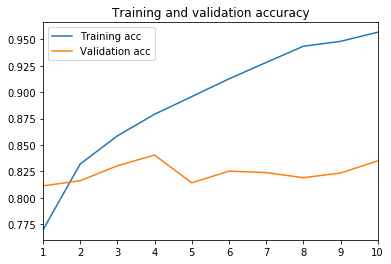

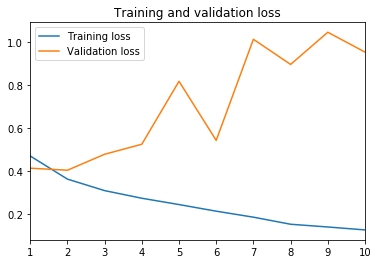

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(len(acc)) + 1

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlim(1,10)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlim(1,10)

Validation accuracy is getting saturated around 84 %. I have only done an elemntary parameter tuning. Extensive tuning would probably lead to an even better performance.
Now let us train the model with the enitre training and validation set. n_epochs is set to 4 as validation accuracy decreases after that.

In [11]:
X = np.stack((vrt,geopt,cloud,pr),axis=3)
X = X[idx]
Y = cyclone_label[idx]

ntotal = len(Y)
ntrain = int(0.6*ntotal)
nval   = int(0.2*ntotal)
ntest  = ntotal - ntrain - nval
trainIdx = np.random.permutation(ntrain)
valIdx   = np.random.permutation(nval) + ntrain
testIdx  = np.random.permutation(ntest) + ntrain + nval

trainIdx = np.append(trainIdx,valIdx) # use both training and validation data

X_train = X[trainIdx]
Y_train = Y[trainIdx]
X_test  = X[testIdx]
Y_test  = Y[testIdx]

print ("X_train shape:", X_train.shape)
print ("X_test shape:", X_test.shape)

X_train shape: (18101, 54, 121, 4)
X_test shape: (4527, 54, 121, 4)


In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                        input_shape=(X.shape[1], X.shape[2], X.shape[3])))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=4, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 121, 8)        296       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 60, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 60, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 30, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 30, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 15, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 15, 64)         18496     
__________

In [13]:
loss, accuracy = model.evaluate(X_test, Y_test)
print ("Test Loss:", loss)
print ("Test Accuracy:", accuracy)

4527/4527 [==============================] - 3s 661us/step
Test Loss: 0.3774436233136889
Test Accuracy: 0.8436050365006447


Confusion matrix is plotted below.

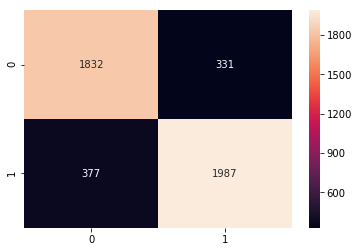

In [14]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_classes(X_test)
cmat =  confusion_matrix(Y_test,Y_pred)
seaborn.heatmap(cmat, annot=True,fmt='g')

Test data has an accuracy of about 84 % similar to the validation set. Model seems to be perfoming fairly good. 
Further inclusion of additional parameters and better model tuning would perhaps lead to an even better performance.